In [2]:
import numpy as np
import torch
import torch.nn.functional as F

In [36]:
#load the data
dataLR_dict = torch.load("serialized_data/dataLR.pt")
dataHR_dict = torch.load("serialized_data/dataHR.pt")

dataLR_raw = dataLR_dict["data"]
dataHR_raw = dataHR_dict["data"]

/tmp/ipykernel_62874/3307961193.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataLR_dict = torch.load("serialized_data/dataLR.pt")
/tmp/ipykernel_62874/3307961193.py:

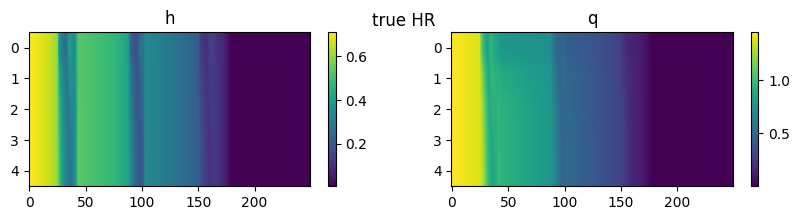

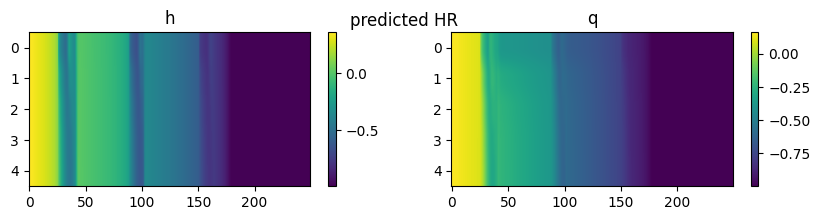

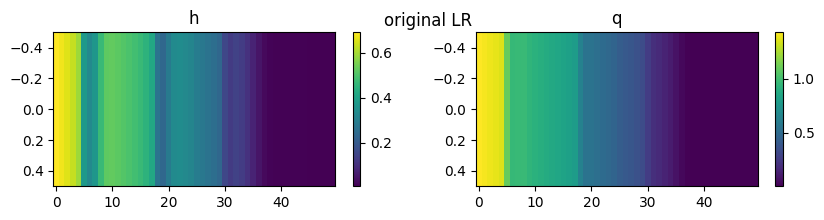

In [41]:
plot_single(dataHR_raw[12, 215], "true HR")
plot_single(dataHR[12, 115], "predicted HR")
plot_single(dataLR_raw[12, 215], "original LR")

In [4]:
import sys
sys.path.append('../downscaling_module')

In [5]:
import torch
from data_visualisation import plot_single, plot_bilinear_interpolation
from downscaling_module.data.datasets import ConvLSTMDataset

In [37]:
from downscaling_module.data.transforms import transforms
dataset = ConvLSTMDataset(dataLR_raw, dataHR_raw, transform=transforms)

Transforming with cutSequence
Transforming with bilinearInterpolation
Before interpolation:
LR: torch.Size([14, 501, 2, 1, 50]) HR: torch.Size([14, 501, 2, 5, 250])
Reshaped LR: torch.Size([7014, 2, 1, 50])
HR: torch.Size([14, 501, 2, 5, 250])
After interpolation:
LR resized: torch.Size([14, 501, 2, 5, 250]) HR: torch.Size([14, 501, 2, 5, 250])
Transforming with min_max_scale


In [49]:
dataLR, dataHR = dataset[:]
print(dataLR.shape, dataHR.shape)

#reshape data
dataLR_reshaped = dataLR.reshape(dataLR.shape[0]*dataLR.shape[1]*dataLR.shape[2], dataLR.shape[3], dataLR.shape[4])
dataHR_reshaped = dataHR.reshape(dataHR.shape[0]*dataHR.shape[1]*dataHR.shape[2], dataHR.shape[3], dataHR.shape[4])

dataLR_reshaped_keep_time = dataLR.reshape(dataLR.shape[0], dataLR.shape[1]*dataLR.shape[2], dataLR.shape[3], dataLR.shape[4])
dataHR_reshaped_keep_time = dataHR.reshape(dataHR.shape[0], dataHR.shape[1]*dataHR.shape[2], dataHR.shape[3], dataHR.shape[4])

dataLR_reshaped_B_C_H_W = dataLR.reshape(dataLR.shape[0]*dataLR.shape[1], dataLR.shape[2], dataLR.shape[3], dataLR.shape[4])
dataHR_reshaped_B_C_H_W = dataHR.reshape(dataHR.shape[0]*dataHR.shape[1], dataHR.shape[2], dataHR.shape[3], dataHR.shape[4])

print(dataLR_reshaped.shape, dataHR_reshaped.shape)
print(dataLR_reshaped_keep_time.shape, dataHR_reshaped_keep_time.shape)
print(dataLR_reshaped_B_C_H_W.shape, dataHR_reshaped_B_C_H_W.shape)

torch.Size([14, 501, 2, 5, 250]) torch.Size([14, 501, 2, 5, 250])
torch.Size([14028, 5, 250]) torch.Size([14028, 5, 250])
torch.Size([14, 1002, 5, 250]) torch.Size([14, 1002, 5, 250])
torch.Size([7014, 2, 5, 250]) torch.Size([7014, 2, 5, 250])


In [16]:
import ignite
from ignite.engine import Engine, Events
from ignite.metrics import SSIM

ssim_metric = SSIM(data_range=1.0, kernel_size=9, sigma=1.5)

def evaluate(engine, batch):
    y_pred, y = batch
    return y_pred, y

evaluator = Engine(evaluate)

ssim_metric.attach(evaluator, "ssim")

evaluator.run([[dataLR_reshaped.unsqueeze(0), dataHR_reshaped.unsqueeze(0)]])

print(f"SSIM score: {evaluator.state.metrics['ssim']}")


SSIM score: 0.9003780448455373


In [22]:
ssim_scores = []
for i in range(dataHR.shape[0]):
    evaluator.run([[dataLR_reshaped_keep_time[i].unsqueeze(0), dataHR_reshaped_keep_time[i].unsqueeze(0)]])
    print(f"SSIM score for simulation {i} : {evaluator.state.metrics['ssim']}")
    ssim_scores.append(evaluator.state.metrics['ssim'])

SSIM score for simulation 0 : 0.9795112479409415
SSIM score for simulation 1 : 0.9508275190078754
SSIM score for simulation 2 : 0.9238043025895784
SSIM score for simulation 3 : 0.9575301674434848
SSIM score for simulation 4 : 0.9152765439682644
SSIM score for simulation 5 : 0.8708986899395813
SSIM score for simulation 6 : 0.9026215967445168
SSIM score for simulation 7 : 0.8663699862258155
SSIM score for simulation 8 : 0.8690141539219507
SSIM score for simulation 9 : 0.9191835505026547
SSIM score for simulation 10 : 0.9167525471083275
SSIM score for simulation 11 : 0.8946090623896381
SSIM score for simulation 12 : 0.8244786800658029
SSIM score for simulation 13 : 0.8144145799890895


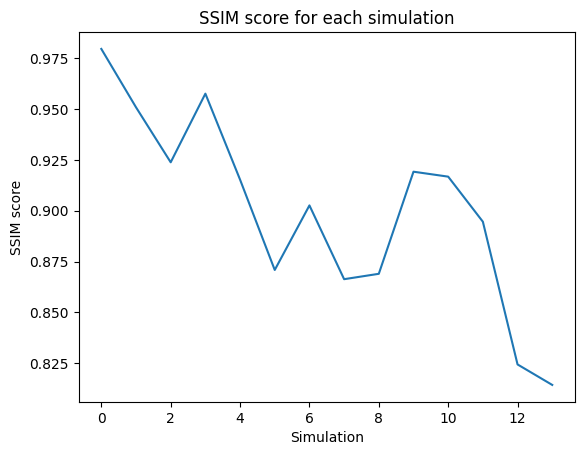

In [20]:
#plot the scores
import matplotlib.pyplot as plt
plt.plot(ssim_scores)
plt.xlabel("Simulation")
plt.ylabel("SSIM score")
plt.title("SSIM score for each simulation")
plt.show()